<a href="https://colab.research.google.com/github/130ndim/dul_2021/blob/hw7/Homework/hw7/Homework7_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 260 (delta 61), reused 49 (delta 49), pack-reused 163
Receiving objects: 100% (260/260), 53.29 MiB | 25.66 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=22409 sha256=09bba3a4208e7d96f917eefbd6f88af4934796afb60bb5611f9539d753edebea
  Stored in directory: /tmp/pip-ephem-wheel-cache-wf947acr/wheels/55/59/29/0fb1c635652157734

In [39]:
from dul_2021.utils.hw7_utils import *

import math

import numpy as np
import matplotlib.pyplot as plt
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.optim import Adam
from torch.optim.lr_scheduler import LinearLR

from tqdm.auto import tqdm

import copy

from scipy.stats import norm
from scipy.optimize import bisect
from tqdm import trange, tqdm_notebook

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1: GANs on CIFAR-10

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

Files already downloaded and verified


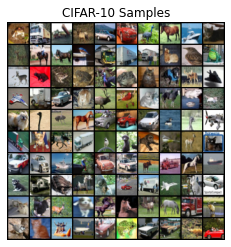

In [41]:
visualize_q1_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Discriminator loss across training
3. 100 samples. 

In [42]:
class Reshape(nn.Module):
    def __init__(self, *size):
        super().__init__()
        self.size = size
        
    def forward(self, x):
        return x.reshape(*self.size)
    
    def __repr__(self):
        return f'{self.__class__.__name__}{self.size}'


class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = torch.stack([t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl], dim=0)
        output = stack.transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width, s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        output = torch.stack([t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1], dim=1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output
    

# Spatial Upsampling with Nearest Neighbors
class UpsampleConv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding)
        self.d2s = nn.PixelShuffle(2)
        
    def forward(self, x):
        x = torch.cat([x, x, x, x], dim=1)
        x = self.d2s(x)
        x = self.conv(x)
        return x


# Spatial Downsampling with Spatial Mean Pooling
class DownsampleConv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding)
        self.s2d = nn.PixelUnshuffle(2)
        
    def forward(self, x):
        x = self.s2d(x)
        x = sum(x.chunk(4, dim=1)) / 4.
        x = self.conv(x)
        return x
    

class ResNetBlockUp(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), padding=1, n_filters=256):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm2d(in_dim),
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=padding),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            UpsampleConv2d(n_filters, n_filters, kernel_size, padding=padding)
        )
        self.up = UpsampleConv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)
        
    def forward(self, x):
        return self.block(x) + self.up(x)

    
class ResNetBlockDown(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), padding=1, n_filters=256):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=padding),
            nn.ReLU(),
            DownsampleConv2d(n_filters, n_filters, kernel_size, padding=padding)
        )
        self.up = DownsampleConv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)
        
    def forward(self, x):
        return self.block(x) + self.up(x)
    
    
class Generator(nn.Module):
    def __init__(self, in_dim, n_filters=128):
        super().__init__()
        self.in_dim = in_dim
        self.n_filters = n_filters
        self.seq = nn.Sequential(
            nn.Linear(in_dim, 4*4*256),
            Reshape(-1, 256, 4, 4),
            ResNetBlockUp(in_dim=256, n_filters=n_filters),
            ResNetBlockUp(in_dim=n_filters, n_filters=n_filters),
            ResNetBlockUp(in_dim=n_filters, n_filters=n_filters),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.seq(x)
    
    def sample(self, n):
        return self(torch.randn(n, self.in_dim, device=device))
    
    
class Discriminator(nn.Module):
    def __init__(self, n_filters=128):
        super().__init__()
        self.n_filters = n_filters
        self.seq = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=(1, 1)),
            ResNetBlockDown(in_dim=256, n_filters=n_filters),
            ResNetBlockDown(in_dim=n_filters, n_filters=n_filters),
            ResNetBlockDown(in_dim=n_filters, n_filters=n_filters),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            Reshape(-1, n_filters),
            nn.Linear(n_filters, 1)
        )
        
    def forward(self, x):
        return self.seq(x)
    
    
class WGANGP(nn.Module):
    def __init__(
        self, in_dim=128, n_filters=128, lr=2e-4, betas=(0., 0.9), lambda_=10., n_critic=5, n_steps=1000
    ):
        super().__init__()
        self.in_dim = in_dim
        self.lambda_ = lambda_
        self.n_critic = n_critic
        self.n_steps = n_steps
        
        self.g = Generator(in_dim, n_filters)
        self.d = Discriminator(n_filters)
        
        self.g_opt = Adam(self.g.parameters(), lr=lr, betas=betas)
        self.d_opt = Adam(self.d.parameters(), lr=lr, betas=betas)
        
        self.g_steps = n_steps / (n_critic + 1)
        self.d_steps = n_steps - self.g_steps
        
        self.g_steps = math.ceil(self.g_steps)
        self.d_steps = math.ceil(self.d_steps)
        
        self.g_sch = LinearLR(self.g_opt, start_factor=1, end_factor=0, total_iters=self.g_steps)
        self.d_sch = LinearLR(self.d_opt, start_factor=1, end_factor=0, total_iters=self.d_steps)
        
        self._critic_losses = []
        
        self._postfix_dict = {}
        
    def forward(self, n):
        return self.g.sample(n)
    
    @torch.no_grad()
    def sample(self, n):
        noise_dl = data.DataLoader(torch.randn(n, self.in_dim), batch_size=64)
        samples = []
        for batch in noise_dl:
            samples.append(self.g(batch.to(device)).cpu())
        return torch.cat(samples, dim=0)
        
    def train(self, train_dl):
        self._critic_losses = []
        self._postfix_dict = {}

        steps = 0
        self._pbar = tqdm(total=self.n_steps)
        while steps < self.n_steps:
            for batch in train_dl:
                batch = batch.to(device)

                if steps % self.n_critic == 0:
                    fake_batch = self(batch.size(0))
                    self._g_step(fake_batch)
                    steps += 1
                    self._pbar.update()
                
                fake_batch = self(batch.size(0))
                self._d_step(batch, fake_batch)
                steps += 1
                self._pbar.update()

                if steps >= self.n_steps:
                    break
                    
        self._pbar.close()
        out = np.array(self._critic_losses)
        self._critic_losses = []
        return out
        
    def _gp(self, batch, fake_batch):
        alpha = torch.rand((batch.size(0), 1, 1, 1), device=batch.device)
        
        interp = (batch * alpha + fake_batch * (1 - alpha)).requires_grad_()
        
        d_interp_out = self.d(interp)
        
        grad = torch.autograd.grad(
            outputs=d_interp_out, inputs=interp,
            grad_outputs=torch.ones_like(d_interp_out),
            create_graph=True, retain_graph=True
        )[0]
        
        gp = (grad.norm(2, dim=(-1, -2, -3)) - 1.).pow(2).mean()
        self._postfix_dict.update({'gp': gp.item()})
        self._pbar.set_postfix(self._postfix_dict, refresh=False)
        return gp
        
        
    def _g_step(self, fake_batch):
        self.g_opt.zero_grad()
        g_loss = -self.d(fake_batch).mean()
        
        g_loss.backward()
        self.g_opt.step()
        self.g_sch.step()
        
        self._postfix_dict.update({'g_loss': g_loss.item(), 'g_lr': self.g_sch.get_last_lr()[0]})
        self._pbar.set_postfix(self._postfix_dict, refresh=False)

        
    def _d_step(self, batch, fake_batch):
        self.d_opt.zero_grad()
        d_real_loss = self.d(batch).mean()
        d_fake_loss = self.d(fake_batch).mean()

        d_loss = d_fake_loss - d_real_loss + self.lambda_ * self._gp(batch, fake_batch)

        self._critic_losses.append(d_loss.item())
        
        d_loss.backward()
        self.d_opt.step()
        self.d_sch.step()
        
        self._postfix_dict.update({'d_loss': d_loss.item(), 'd_lr': self.d_sch.get_last_lr()[0]})
        self._pbar.set_postfix(self._postfix_dict, refresh=False)


## Solution

In [ ]:
def q1(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    gan = WGANGP()
    gan.to(device)
    
    train_dl = data.DataLoader(2 * train_data.astype(np.float32) - 1, batch_size=256, shuffle=True)
    
    train_losses = gan.train(train_dl)
    
    with torch.no_grad():
        gen = gan.sample(1000)
    
    gen = 0.5 * (gen.permute(0, 2, 3, 1).numpy() + 1)
    
    return train_losses, gen

## Results

Files already downloaded and verified


  0%|          | 0/1000 [00:00<?, ?it/s]

..........Inception score: 2.0808473


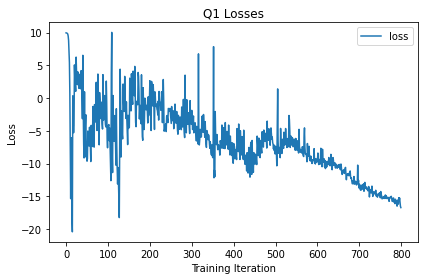

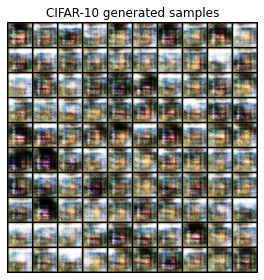

In [ ]:
q1_save_results(q1)

Надо дольше учить, но колаб слишком медленный для этого



# Question 2: Representation Learning with BiGAN on MNIST

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


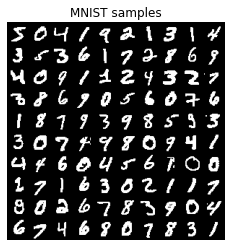

In [ ]:
visualize_q2_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


In [64]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(50, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.seq(x).reshape(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(784 + 50, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, z):
        x = x.reshape(-1, 784)
        return self.seq(torch.cat([x, z], dim=1))
    
    
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            Reshape(-1, 784),
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 50)
        )
        
    def forward(self, x):
        return self.seq(x)
    
    
class BiGAN(nn.Module):
    def __init__(self, n_steps, lr=2e-4, betas=(0., 0.9)):
        super().__init__()
        self.n_steps = n_steps
        
        self.g = Generator()
        self.d = Discriminator()
        self.e = Encoder()
        
        self.g_opt = Adam(list(self.g.parameters()) + list(self.e.parameters()), lr=lr, betas=betas, weight_decay=1e-4)
        self.d_opt = Adam(self.d.parameters(), lr=lr, betas=betas, weight_decay=1e-4)
        
        self.g_steps = n_steps // 2
        self.d_steps = n_steps - self.g_steps
        
        self.g_sch = LinearLR(self.g_opt, start_factor=1, end_factor=0, total_iters=self.g_steps)
        self.d_sch = LinearLR(self.d_opt, start_factor=1, end_factor=0, total_iters=self.d_steps)
        
        self._postfix_dict = {}
        
        self.lin = nn.Linear(50, 10)
        
    def fit(self, dl):
        losses = []
        self.train()
        
        pbar_dict = {}
        steps = 0
        with tqdm(total=self.n_steps) as pbar:
            while steps < self.n_steps:
                for x, y in dl:
                    x = x.to(device)
                    
                    d_loss = self._d_loss(x)
                    self.d_opt.zero_grad()
                    d_loss.backward()
                    self.d_opt.step()
                    self.d_sch.step()
                    pbar_dict.update(dict(d_loss=round(d_loss.item(), 3), d_lr=self.d_sch.get_last_lr()[0]))
                    pbar.set_postfix(pbar_dict, refresh=False)
                    pbar.update(1)
                    
                    g_loss = -self._d_loss(x)
                    self.g_opt.zero_grad()
                    g_loss.backward()
                    self.g_opt.step()
                    self.g_sch.step()
                    pbar_dict.update(dict(g_loss=round(g_loss.item(), 3), g_lr=self.g_sch.get_last_lr()[0]))
                    pbar.set_postfix(pbar_dict, refresh=False)
                    pbar.update(1)
                    
                    losses.append(d_loss.item())
                    
                    steps += 2
                    
                    if steps >= self.n_steps:
                        break
                        
        return np.array(losses)
        
    def _d_loss(self, batch):
        z_real = self.e(batch)
        z_fake = torch.randn_like(z_real)
        fake_batch = self.g(z_fake)

        d_loss = -0.5 * self.d(batch, z_real).clamp(1e-6, 1 - 1e-6).log().mean() - 0.5 * (1 - self.d(fake_batch, z_fake)).clamp(1e-6, 1 - 1e-6).log().mean()
        return d_loss
    
    def train_clf(self, dl, n_epochs=10):
        self.lin.reset_parameters()
        lin_opt = Adam(self.lin.parameters(), lr=1e-3)
        
        self.e.eval()
        with torch.no_grad():
            xs, ys = [], []
            for x, y in tqdm(dl, desc='Encoding'):
                xs.append(self.e(x.to(device)).cpu())
                ys.append(y)
            xs = torch.cat(xs, dim=0)
            ys = torch.cat(ys, dim=0)
            
        enc_dl = data.DataLoader(data.TensorDataset(xs, ys), batch_size=256)
        
        losses = []
        with tqdm(range(n_epochs)) as pbar:
            for _ in pbar:
                ep_loss = 0.
                for x, y in enc_dl:
                    x, y = x.to(device), y.to(device)
                    pred = self.lin(x)
                    loss = F.cross_entropy(pred, y)
                    loss.backward()
                    lin_opt.step()
                    
                    ep_loss += loss.item()
                    
                    losses.append(loss.item())
                
                pbar.set_postfix({'loss': round(ep_loss / len(enc_dl), 3)})
                
        return np.array(losses)
    
    def sample(self, n):
        self.g.eval()
        
        x = torch.randn(n, 50, device=device)
        return self.g(x)
    
    def reconstruct(self, x):
        self.e.eval()
        self.g.eval()
        
        l = self.e(x)
        out = self.g(l)
        return out
            

## Solution

In [65]:
def q2(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    train_dl = data.DataLoader(train_data, batch_size=256, shuffle=True, drop_last=True)
    test_dl = data.DataLoader(train_data, batch_size=256)
    
    model = BiGAN(5000)
    model.to(device)
    
    random_losses = model.train_clf(train_dl)
    
    bigan_losses = model.fit(train_dl)
    
    trained_losses = model.train_clf(train_dl)
    
    train_batch = torch.tensor(test_data.data[-20:].unsqueeze(1) / 255. * 2. - 1., dtype=torch.float32)
    
    with torch.no_grad():
        samples = model.sample(100).view(-1, 28, 28, 1).cpu().numpy()
        samples = 0.5 * (samples + 1)
        recs = torch.cat([train_batch, model.reconstruct(train_batch.to(device)).cpu()], dim=0)
        recs = recs.view(-1, 28, 28, 1).cpu().numpy()
        recs = 0.5 * (recs + 1)
        
    return bigan_losses, samples, recs, trained_losses, random_losses
        
        

## Results

Encoding:   0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Encoding:   0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


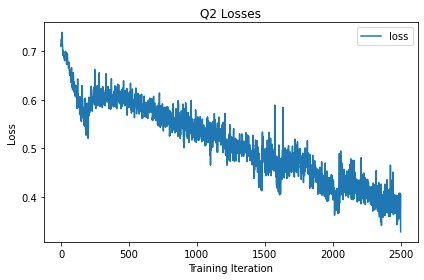

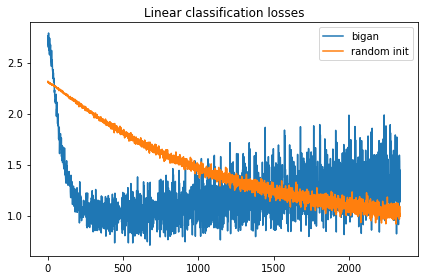

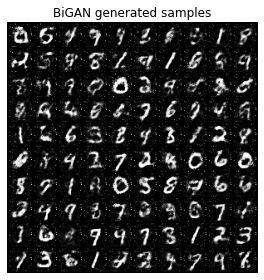

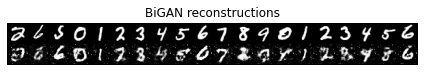

BiGAN final linear classification loss: 1.4447698593139648
Random encoder linear classification loss: 1.0192112922668457


In [66]:
q2_save_results(q2)

# Bonus 5: CycleGAN
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

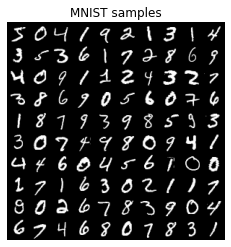

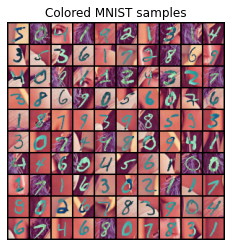

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def b5(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

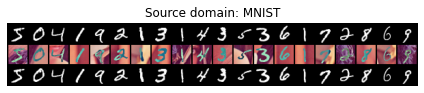

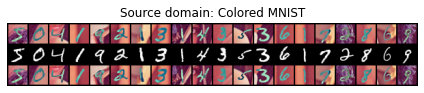

In [ ]:
b5_save_results(b5)